# Resultados de teste do robot Caixote, desde o início do ano

Observação: Operações com Win são mostradas como uma série continua

Conecta com MetaTrader

In [61]:
############################################
# Init: setup, imports and connects to MT5 #
############################################

# específico para jupyter notebook
%matplotlib inline 
#%matplotlib notebook

from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import MetaTrader5 as mt5

#plt.ion() #descomentar para usar gráficos interativos

# configs
pd.set_option('display.max_columns', 500) # number of columns to be displayed
pd.set_option('display.width', 1500)      # max table width to display
# display data on the MetaTrader 5 package // exibe dados do MT5
print("MetaTrader5 package author: " ,mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)
print()
# establish connection to the MetaTrader 5 terminal // tenta conectar com MT5 ou quit
if not mt5.initialize():
    print("initialize() falhou, código de erro =",mt5.last_error())
    quit()
print("Conectado com sucesso")

MetaTrader5 package author:  MetaQuotes Software Corp.
MetaTrader5 package version:  5.0.34

Conectado com sucesso


## Busca os dados de negociações

Define as datas de inicio e fim da busca.

In [79]:
# get deals from/to dates and show number of deals
from_date = datetime(2020, 5, 1) 
to_date = datetime.now()
#to_date = datetime(2021, 5, 1) 

Consulta o banco de dados de negociações e exibe o número de negócios no período ou mensagem de erro se não achar nada

In [80]:
deals = mt5.history_deals_get(from_date, to_date) # recebe negócios com datas de from_date até to_date

# deals # <-- descomentar para ver os dados raw das operações
if deals == None:
    print("Nenhum negócio encontrado, código de erro={}" . format(mt5.last_error()))
    quit()
elif len(deals) > 0:
    print("Houve", len(deals), "negócios desde",  from_date, "até", to_date)

Houve 4151 negócios desde 2020-05-01 00:00:00 até 2021-05-30 20:53:33.807482


Exibe os dados de negociações consultadas (para debug)

In [81]:
# list deals one by own // descomenta as próximas 3 linhas 
#print("Exibindo negócios um a um: ", len(deals))
#for deal in deals:
#   print(" ",deal) # mostra cada negócio realizado do jeito que vem

Cria o Data Frame

In [82]:
# create dataFrame from deals and add some columns
print("Cria Data Frame contendo", len(deals), "negócios")
# display these deals as a table using pandas.DataFrame
df = pd.DataFrame(list(deals), columns = deals[0]._asdict().keys())

Cria Data Frame contendo 4151 negócios


Prepara os dados

    Acerta coluna de datas para formato legível
    
    Mescla as negóciações de WIN como se fosse uma série contínua

In [83]:
# insert readable datetime column // transforma em data legível
df['time'] = pd.to_datetime(df['time'], unit = 's') 

In [84]:
# Refaz o nome de symbol de forma a juntar excluir o quarto character do rótulo,
# de forma a dar continuidade a curva do gráfico
df["symbol"] = np.where(df["symbol"].str.slice(0, 3) == "WIN", "WIN$", df["symbol"])

In [85]:
print (from_date, to_date)

2020-05-01 00:00:00 2021-05-30 20:53:33.807482


**Normaliza valores das operações**

Se for ação, reduz volume a um lote (100 unidades) e ajusta o valor

Se for indice, reduz volume a uma unidade e ajusta o valor


In [86]:
df['newProfit'] = np.where(df["symbol"].str.slice(0, 3) == "WIN", 
                           (df["profit"] / df["volume"] ), 
                           (df["profit"] / (df["volume"] /100))
                          )

Remove colunas desnecessárias

In [87]:
# remove unused columns
df.drop(["external_id", "magic", "swap", "commission", "fee", "price", "ticket", 
         "order", "time_msc", "type", "entry", "position_id", "reason", "comment"], inplace=True, axis=1)
# DEBUG: mostra resultado #df.head(20)

Cria coluna do acumulador de resultados por ativo

In [88]:
df["amount"] = df.groupby(["symbol"]).newProfit.cumsum() # acumula profit normalizado e agrupado por símbolo

Debug: Exibe uma amostra dos dados tratados e acumulados para conferência

In [89]:
# DEBUG: mostra resultado # df.head(20)

Agrupa os dados por Ativo e mostra o número de negócios por ativo

In [90]:
dfg = df.groupby("symbol")
dfg.count().profit

symbol
BBAS3    260
BBDC3    290
CSNA3    178
ITSA4    416
ITUB3    214
PETR4    894
USIM5    852
VALE3    552
VVAR3    208
WIN$     287
Name: profit, dtype: int64

Plota os dados

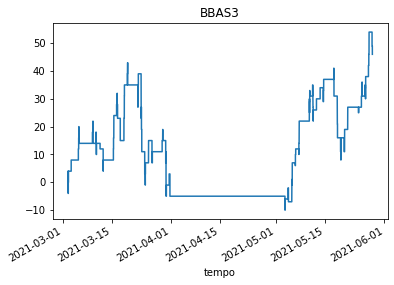

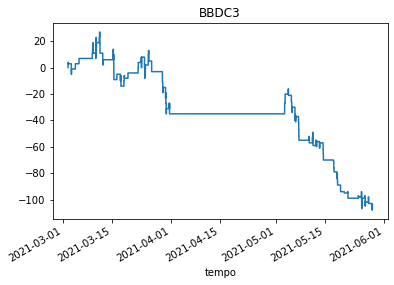

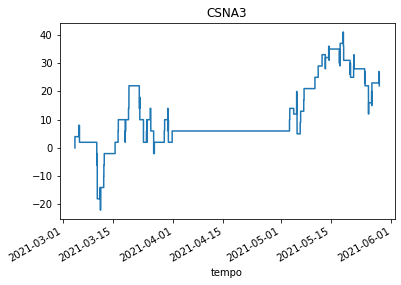

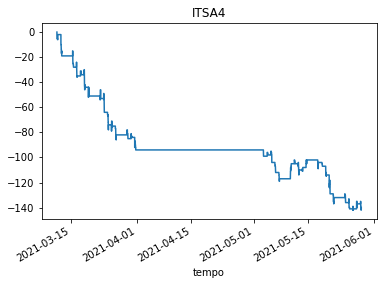

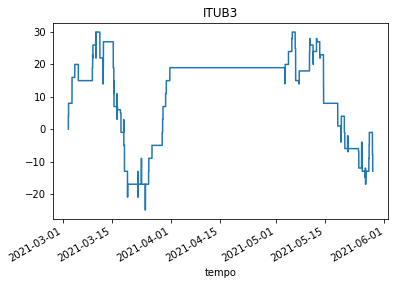

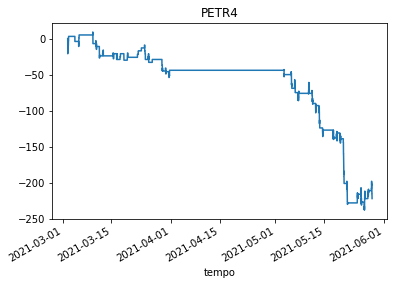

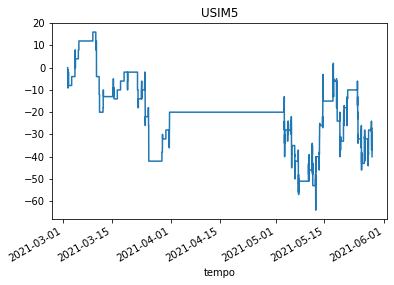

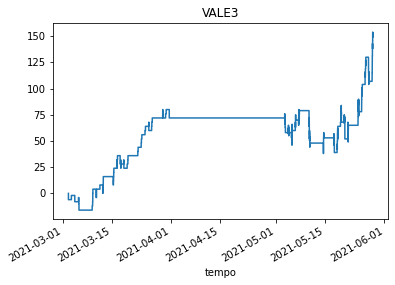

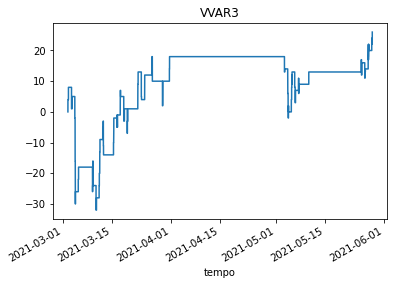

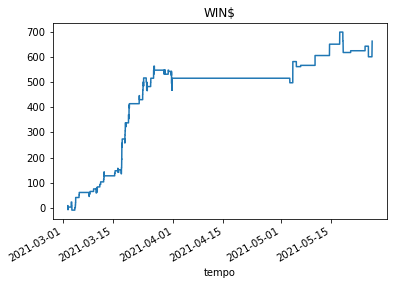

In [95]:
# iterage com cada item do grupo para personalizar o ylabel
for name, group in dfg:
    group.plot(x='time', y='amount',xlabel='tempo', legend=False, title=name)
plt.show();

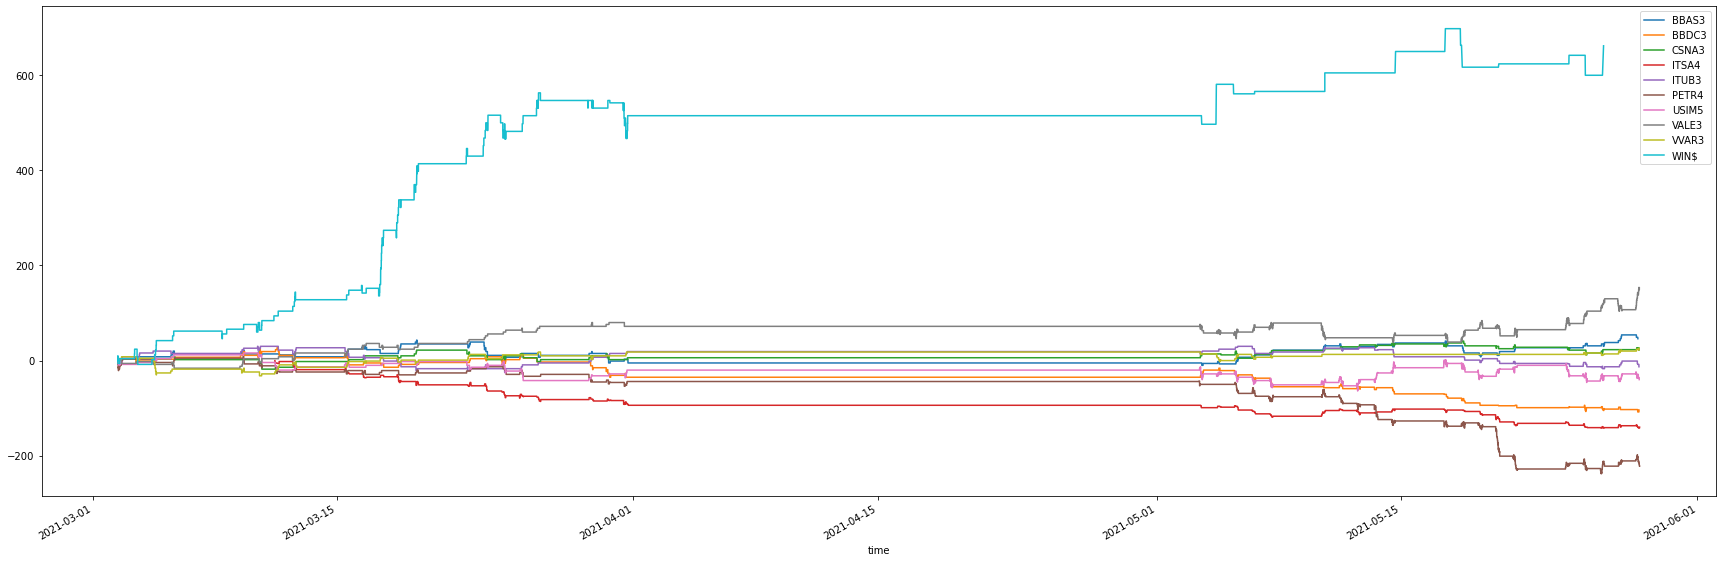

In [92]:
# iterage com o grupo para exibir todas as curvas no mesmo gráfico
fig, ax = plt.subplots(figsize=(30,10))
for name, group in dfg:    
    group.plot(x='time', y='amount', ax=ax, label=name)
plt.legend(loc=0)
plt.show()

In [93]:
to_date

datetime.datetime(2021, 5, 30, 20, 53, 33, 807482)